In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import sparse
import scipy.sparse.linalg
from pyunlocbox import functions, solvers
import datetime, warnings, scipy 
import seaborn as sns
import networkx as nx

In [2]:
airlines = pd.read_csv('airlines.csv')
airports = pd.read_csv('airports.csv')
flights = pd.read_csv('flights.csv',low_memory=False)
abbr_companies = airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()

---
### Pre-processing

In [3]:
# we are not interested in cancelled flights
# also, we want to use destination airport as our features, so we do not take diverted flights into account
# (diverted means arriving at other airport)
flights = flights.loc[flights.CANCELLED==0]
flights = flights.loc[flights.DIVERTED==0]
flights.reset_index(drop=True,inplace=True)

In [4]:
flights.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [5]:
df_aircode1 = pd.read_csv('L_AIRPORT.csv')
df_aircode2 = pd.read_csv('L_AIRPORT_ID.csv')
df_aircode1 = df_aircode1.reset_index()
df_aircode2 = df_aircode2.reset_index()
df_aircodes = pd.merge(df_aircode1,df_aircode2,on='Description')
aircode_dict = dict(zip(df_aircodes['Code_y'].astype(str),df_aircodes['Code_x']))

# Make sure all Origin and departing airports are strings
flights['ORIGIN_AIRPORT'] = flights['ORIGIN_AIRPORT'].values.astype(str)
flights['DESTINATION_AIRPORT'] = flights['DESTINATION_AIRPORT'].values.astype(str)

In [10]:
df = flights.copy()
five_digit = flights.loc[flights.MONTH==10].ORIGIN_AIRPORT.unique()

for i in range(len(five_digit)):
    to_replace = five_digit[i]
    value = aircode_dict[five_digit[i]]
    df.ORIGIN_AIRPORT = df.ORIGIN_AIRPORT.replace(to_replace, value)
    df.DESTINATION_AIRPORT = df.DESTINATION_AIRPORT.replace(to_replace, value)
    print(i,'replaced',to_replace,'with',value)

0 replaced 14747 with SEA
1 replaced 14771 with SFO
2 replaced 12889 with LAS
3 replaced 12892 with LAX
4 replaced 14869 with SLC
5 replaced 10299 with ANC
6 replaced 11292 with DEN
7 replaced 14107 with PHX
8 replaced 11630 with FAI
9 replaced 10732 with BQN
10 replaced 14254 with PSE
11 replaced 10141 with ABR
12 replaced 10627 with BIS
13 replaced 11982 with GRK
14 replaced 12173 with HNL
15 replaced 13930 with ORD
16 replaced 14683 with SAT
17 replaced 12266 with IAH
18 replaced 11618 with EWR
19 replaced 10721 with BOS
20 replaced 13487 with MSP
21 replaced 11884 with GEG
22 replaced 15919 with XNA
23 replaced 13851 with OKC
24 replaced 11111 with COU
25 replaced 10693 with BNA
26 replaced 12191 with HOU
27 replaced 14783 with SGF
28 replaced 15016 with STL
29 replaced 14487 with RDD
30 replaced 10423 with BSM
31 replaced 15370 with TUL
32 replaced 11953 with GNV
33 replaced 13891 with ONT
34 replaced 15376 with TUS
35 replaced 11778 with FSM
36 replaced 11278 with DCA
37 replaced

297 replaced 13541 with MVY
298 replaced 15027 with STX
299 replaced 10170 with ADQ
300 replaced 10165 with ADK
301 replaced 15497 with UST
302 replaced 12265 with IAG
303 replaced 14222 with PPG
304 replaced 14025 with PBG
305 replaced 13502 with MTJ


In [13]:
flights = df

In [14]:
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
    return pd.Series(liste)

In [15]:
flights['DATE'] = pd.to_datetime(flights[['YEAR','MONTH', 'DAY']])
flights['SCHEDULED_DEPARTURE'] = flights['SCHEDULED_DEPARTURE'].apply(format_heure)
flights['SCHEDULED_ARRIVAL'] = flights['SCHEDULED_ARRIVAL'].apply(format_heure)
flights['DEPARTURE_TIME'] = flights['DEPARTURE_TIME'].apply(format_heure)
flights['ARRIVAL_TIME'] = flights['ARRIVAL_TIME'].apply(format_heure)

In [16]:
flights.to_csv('flights_clean.csv',index=False)

In [17]:
flights = flights[['DATE','MONTH','DAY','DAY_OF_WEEK',
                  'AIRLINE','FLIGHT_NUMBER','ORIGIN_AIRPORT','DESTINATION_AIRPORT',
                  'SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL','DEPARTURE_DELAY','ARRIVAL_DELAY',
                  'AIR_TIME','DISTANCE']]

In [18]:
flights.head(5)

,DATE,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_DELAY,ARRIVAL_DELAY,AIR_TIME,DISTANCE
0,2015-01-01,1,1,4,AS,98,ANC,SEA,00:05:00,04:30:00,-11.0,-22.0,169.0,1448
1,2015-01-01,1,1,4,AA,2336,LAX,PBI,00:10:00,07:50:00,-8.0,-9.0,263.0,2330
2,2015-01-01,1,1,4,US,840,SFO,CLT,00:20:00,08:06:00,-2.0,5.0,266.0,2296
3,2015-01-01,1,1,4,AA,258,LAX,MIA,00:20:00,08:05:00,-5.0,-9.0,258.0,2342
4,2015-01-01,1,1,4,AS,135,SEA,ANC,00:25:00,03:20:00,-1.0,-21.0,199.0,1448


---

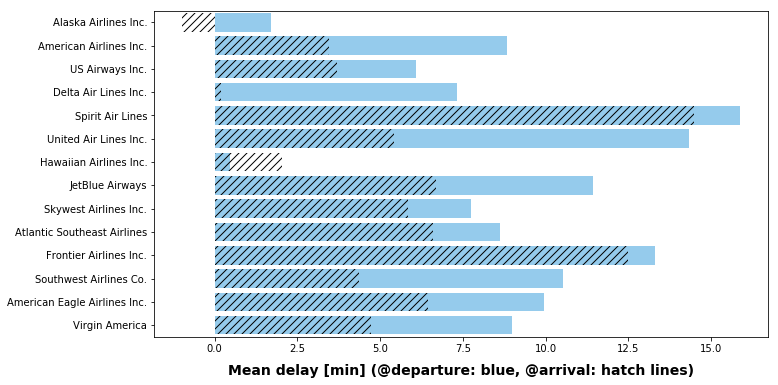

In [10]:
df = flights.copy()
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);


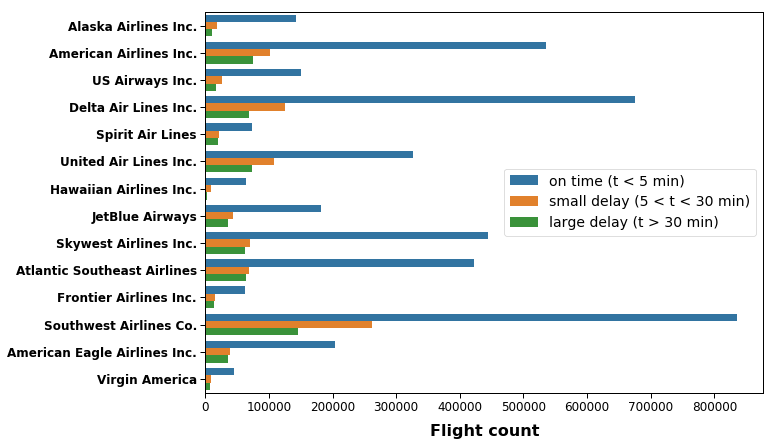

In [53]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 30]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 30 min)')
L.get_texts()[2].set_text('large delay (t > 30 min)')
plt.show()

To see if the day of week of a flight will influence the delay time.

In [48]:
week_dict = {'1':'Monday','2':"Tuesday",'3':'Wednesday','4':'Thursday','5':'Friday',
            '6':'Saturday','7':'Sunday'}

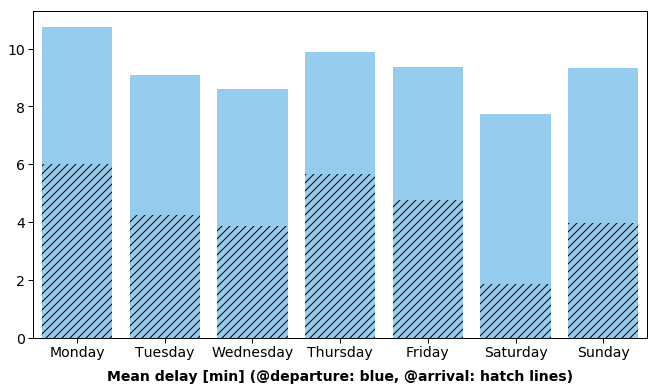

In [51]:
df = flights.copy()
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(y="DEPARTURE_DELAY", x="DAY_OF_WEEK", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(y="ARRIVAL_DELAY", x="DAY_OF_WEEK", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [week_dict[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);


Impact of season(month)

In [56]:
month_dict = {'1':'Jan','2':"Feb",'3':'Mar','4':'Apr','5':'May',
            '6':'Jun','7':'Jul','8':'Aug','9':'Sep','10':'Oct',
             '11':'Nov','12':'Dec'}

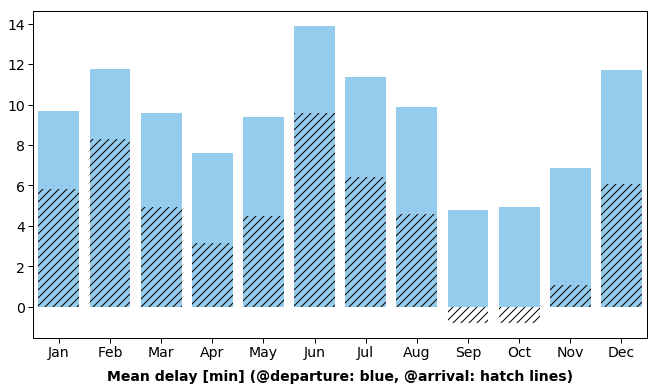

In [57]:
df = flights.copy()
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(y="DEPARTURE_DELAY", x="MONTH", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(y="ARRIVAL_DELAY", x="MONTH", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [month_dict[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);


Mean delay for cities(arrival or depature).